<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Q&A Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to detecting issues with Q&A systems on retrieved context data
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [ ]:
!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken

In [2]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd

In [3]:
import phoenix.experimental.evals.templates.default_templates as templates
from phoenix.experimental.evals import (
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset



- Squad 2:
The 2.0 version of the large-scale dataset Stanford Question Answering Dataset (SQuAD 2.0) allows researchers to design AI models for reading comprehension tasks under challenging constraints.
https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15785042.pdf
- Supplemental Data to Sqaud 2: In order to check the case of detecting incorrect answers, we created wrong answers based on the context data. The wrong answers are intermixed with right answers.
- sampled_answer is a sampled column of randomly original Squad 2 or incorrect answers

In [4]:
df = download_benchmark_dataset(task="qa-classification", dataset_name="qa_generated_dataset")

- **question**: This is the question the Q&A system is running against
- **sampled_answer**: This is a random sample of correct_answer from Squad 2 or wrong_answer which is a made up incorrect answer. This is the column we test against as it has wrong and right answers.
- **correct_answer**: True if answer is correct, False if not. The ground truth to test against.
- **answers**: This is the right answer to the question.
- **wrong_answer**: This is an incorrect answer generated by the context.
- **context**: This is the context to be used to answer the question, and is what Q&A Eval must use to check the correct answer.



In [5]:
df.head()

,id,title,context,question,answers,correct_answer,wrong_answer,sampled_answer,answer_true
0,57317e8d497a881900248f87,Mosaic,"Jerusalem with its many holy places probably had the highest concentration of mosaic-covered churches but very few of them survived the subsequent waves of destructions. The present remains do not do justice to the original richness of the city. The most important is the so-called ""Armenian Mosaic"" which was discovered in 1894 on the Street of the Prophets near Damascus Gate. It depicts a vine with many branches and grape clusters, which springs from a vase. Populating the vine's branches are peacocks, ducks, storks, pigeons, an eagle, a partridge, and a parrot in a cage. The inscription reads: ""For the memory and salvation of all those Armenians whose name the Lord knows."" Beneath a corner of the mosaic is a small, natural cave which contained human bones dating to the 5th or 6th centuries. The symbolism of the mosaic and the presence of the burial cave indicates that the room was used as a mortuary chapel.",When was the Armenian Mosaic re-discovered?,1894,True,The Armenian Mosaic was re-discovered in 1920.,1894,True
1,56cfabed234ae51400d9be49,New_York_City,"The first non-Native American inhabitant of what would eventually become New York City was Dominican trader Juan Rodriguez (transliterated to Dutch as Jan Rodrigues). Born in Santo Domingo of Portuguese and African descent, he arrived in Manhattan during the winter of 1613–1614, trapping for pelts and trading with the local population as a representative of the Dutch. Broadway, from 159th Street to 218th Street, is named Juan Rodriguez Way in his honor.",Who was the first non-Indian person to live in what is now NYC?,Juan Rodriguez,True,The first non-Indian person to live in what is now NYC was Italian explorer Christopher Columbus.,Juan Rodriguez,True
2,571a2c554faf5e1900b8a8f6,Memory,"Short-term memory is supported by transient patterns of neuronal communication, dependent on regions of the frontal lobe (especially dorsolateral prefrontal cortex) and the parietal lobe. Long-term memory, on the other hand, is maintained by more stable and permanent changes in neural connections widely spread throughout the brain. The hippocampus is essential (for learning new information) to the consolidation of information from short-term to long-term memory, although it does not seem to store information itself. Without the hippocampus, new memories are unable to be stored into long-term memory, as learned from patient Henry Molaison after removal of both his hippocampi, and there will be a very short attention span. Furthermore, it may be involved in changing neural connections for a period of three months or more after the initial learning.",Which part of the brain does short-term memory seem to rely on?,frontal lobe (especially dorsolateral prefrontal cortex) and the parietal lobe,True,The cerebellum,frontal lobe (especially dorsolateral prefrontal cortex) and the parietal lobe,True
3,57301bf5b2c2fd1400568889,Roman_Republic,"In 62 BC, Pompey returned victorious from Asia. The Senate, elated by its successes against Catiline, refused to ratify the arrangements that Pompey had made. Pompey, in effect, became powerless. Thus, when Julius Caesar returned from a governorship in Spain in 61 BC, he found it easy to make an arrangement with Pompey. Caesar and Pompey, along with Crassus, established a private agreement, now known as the First Triumvirate. Under the agreement, Pompey's arrangements would be ratified. Caesar would be elected consul in 59 BC, and would then serve as governor of Gaul for five years. Crassus was promised a future consulship.",What provided the Roman senate with exuberance?,successes against Catiline,True,The Roman Senate was filled with exuberance due to Pompey's defeat in Asia.,The Roman Senate was filled with exuberance due to Pompey's defeat in Asia.,False
4,572f8ee0b2c2fd14005681f6,Armenia,"The Seljuk Empire soon started to collapse

## Display Binary Q&A Classification Template

View the default template used to classify hallucinations. You can tweak this template and evaluate its performance relative to the default.

In [6]:
print(templates.QA_PROMPT_TEMPLATE_STR)


You are given a question, an answer and reference text. You must determine whether the
given answer correctly answers the question based on the reference text. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Reference]: {context}
    ************
    [Answer]: {sampled_answer}
    [END DATA]
Your response must be a single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"correct" means that the question is correctly and fully answered by the answer.
"incorrect" means that the question is not correctly or only partially answered by the
answer.



## Configure the API Key

Configure your OpenAI API key.

In [7]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [8]:
df_sample = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)

## LLM Evals: Q&A Classifications GPT-4
Run Q&A classifications against a subset of the data.

Instantiate the LLM and set parameters.

In [9]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [10]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

Run LLM Eval using the template against the dataset: This is the main Eval function

In [11]:
# The rails force the output to specific values of the template
# It will remove text such as ",,," or "...", anything not the
# binary value expected from the template
rails = list(templates.QA_PROMPT_RAILS_MAP.values())
Q_and_A_classifications = llm_classify(
    dataframe=df_sample,
    template=templates.QA_PROMPT_TEMPLATE_STR,
    model=model,
    rails=rails,
)["label"]

  0%|          | 0/100 [00:00<?, ?it/s]



Evaluate the predictions against human-labeled ground-truth Q&A labels.

              precision    recall  f1-score   support

     correct       1.00      1.00      1.00        52
   incorrect       1.00      1.00      1.00        48

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

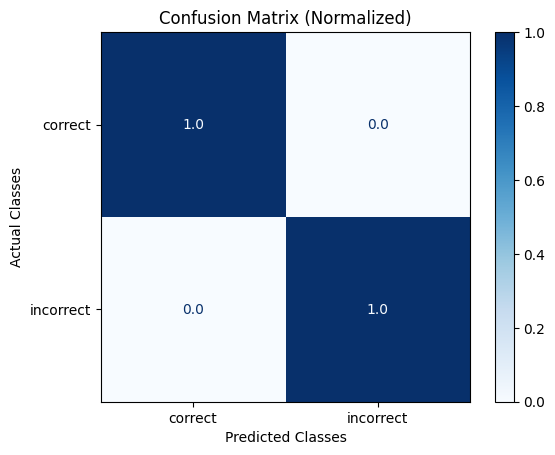

In [12]:
true_labels = df_sample["answer_true"].map(templates.QA_PROMPT_RAILS_MAP).tolist()
Q_and_A_classifications = (
    pd.Series(Q_and_A_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, Q_and_A_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=Q_and_A_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

##  LLM Evals: Q&A Classifications GPT-3.5


Evaluate the predictions against human-labeled ground-truth Q&A labels.

In [13]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [14]:
Q_and_A_classifications = llm_classify(
    dataframe=df_sample,
    template=templates.QA_PROMPT_TEMPLATE_STR,
    model=model,
    rails=list(templates.QA_PROMPT_RAILS_MAP.values()),
)["label"]

  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     correct       0.93      0.98      0.95        52
   incorrect       0.98      0.92      0.95        48

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

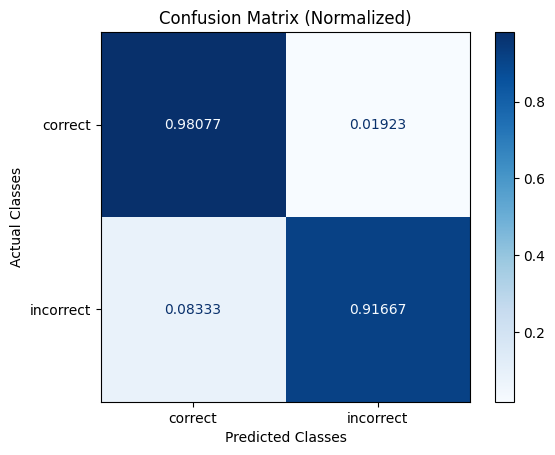

In [15]:
true_labels = df_sample["answer_true"].map(templates.QA_PROMPT_RAILS_MAP).tolist()
classes = list(templates.QA_PROMPT_RAILS_MAP.values())
Q_and_A_classifications = (
    pd.Series(Q_and_A_classifications).map(lambda x: "unparseable" if x is None else x).tolist()
)

print(classification_report(true_labels, Q_and_A_classifications, labels=classes))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=Q_and_A_classifications, classes=classes
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)